# Merge and analyze overnight photometry trials

This script will take individual overnight fiber photometry recording sessions (several hours or more each) and 1) combine them and 2) perform analysis of the combined data.

The individual trials should be together in a directory as .pkl files (output from "Single_Overnight_Analysis.ipynb"), each file name beginning with 'Data_'.

This script outputs a .pkl file containing the merged data ('AllTrialsData.pkl'), and several graphs.

As measures of activity, this script uses both dF/F0 (change in activity relative to pre-stimulus period) and z-scored dF/F0 (i.e. normalized to pre-stimulus signal variance), as well as taking a moving mean of these signals to remove noise and fast-timescale signal fluctuations.

In [1]:
## Take all photometry trials in a directory, merge, and save to file
from tkinter.filedialog import askdirectory
from tkinter import Tk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from os import listdir
from os.path import isfile, join
from itertools import compress
import datetime
from functions.date_range import date_range #in functions folder
from matplotlib.dates import DateFormatter
import seaborn as sns
import pingouin as pg

#######################################
# Set these variables
ConditionsToPlot = ['Veh fast', 'MET fast']#['6pm-8am fast','fed'] # other common options:, "choc 6pm calorie-free"]#,"3pm-8am fast", "12pm-8am fast"]#["6-8 fast Saline", "6-8 fast CNO", "FR1 6-8 fast Saline", "FR1 6-8 fast CNO"]#["6pm-8am fast", "fed", "sham fast", "FR1 6-8 fast", "FR1 fed"]#["6pm-8am fast", "fed", "3pm-8am fast", "12pm-8am fast"] #, "6pm-8am water dep"]
colors = ['orange','purple']#['green','purple'] # other common options:,'darkred']#,'goldenrod','darkred']#['orange','purple','goldenrod','violet']#['green','purple','goldenrod','springgreen','violet']#['green','purple','goldenrod','darkred'] #,'blue'],#orange
MovingMeanVals = [1,5,10,30] # values over which to take moving mean for plots, in mins

# Select only trials beginning at a particular time
# Enter 'All' to include all trials, or number for trials starting at specific hour (in Zeitgeber time - lights on = 0)
TrialsBeginning = 'All'#6
#######################################

ColorsToUse = colors[0:len(colors)]
plt.rcParams['figure.figsize'] = [9,10.5] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.
plt.rcParams.update({'font.size': 16})

In [14]:
# Open a dialog box to select the directory to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# List all files in directory
onlyfiles = [f for f in listdir(Dir2) if isfile(join(Dir2, f))]

# Find .pkl files containing 'Data_'
pklFiles=[]
for i in range(len(onlyfiles)):
    if onlyfiles[i].find('Data_')>-1 and onlyfiles[i].find('.pkl')>-1:
        pklFiles.append(onlyfiles[i])

### Create 'AllTrials' dict, and dataframes within, to contain merged data
# Initialize 'AllTrials' dictionary
my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'MouseTrialID',u'Stim'])
AllTrials = {'Raw':pd.DataFrame(columns = my_cols), 'Raw_DS':pd.DataFrame(columns = my_cols), 
                'dFF0':pd.DataFrame(columns = my_cols), 'z-score':pd.DataFrame(columns = my_cols),
                'Condition':[], 'StartTime':[], 'Events':pd.DataFrame(), 'AnalysisFile':[], 'SamplingRate':[],
                'DownSamplingRate':[], 'MouseID':[], 'MouseTrialID':[]}
TracesToSave = ('Raw', 'Raw_DS', 'dFF0', 'z-score')
MetaToSave = ('Condition','StartTime','AnalysisFile','SamplingRate','DownSamplingRate')

# Loop through trials (=files)
for i in pklFiles:
    with open(i, 'rb') as f:
        TrialData = pickle.load(f)
        # Find MouseID and TrialID from the file name
        MouseID = i[i.find('_')+1:i.find('-')]
        TrialID = i[i.find('-')+1:i.rfind('.')]
        MouseTrialID = MouseID+'_'+TrialID
        TrialData['Events'].columns = [MouseTrialID]

        # For each type of metadata, save to AllTrials
        for j in MetaToSave:
            if type(TrialData[j]) == list: # legacy! in previous versions of single trial script, condition name was saved as 1-element list.
                AllTrials[j].append(TrialData[j][0])
            else:
                AllTrials[j].append(TrialData[j])

        # For each trace type, save to AllTrials
        for j in TracesToSave:
            # In previous versions of single trial script, time was not converted to ZT. If this is the case, then convert by subtracting 6h:
            if TrialData['AnalysisFile'] != 'Single_Overnight_Analysis':
                TrialData[j].index = [k - datetime.timedelta(hours=6) for k in list(TrialData[j].index)]
            ToAdd = pd.DataFrame(list(TrialData[j]['GCaMP']), index = TrialData[j].index, 
                                columns = pd.MultiIndex.from_arrays([[MouseID],[MouseTrialID],[AllTrials['Condition'][-1]]],
                                names = ['MouseID','MouseTrialID','Stim']))
            AllTrials[j] = pd.concat([AllTrials[j],ToAdd],axis=1)
            AllTrials[j] = AllTrials[j].sort_index()
        
        # Add Events and other data
        # As above, convert to ZT by subtracting 6h from event labels if necessary
        if TrialData['AnalysisFile'] != 'Single_Overnight_Analysis':
            TrialData['Events'].index = [k - datetime.timedelta(hours = 6) for k in TrialData['Events'].index]
        AllTrials['Events'] = pd.concat([AllTrials['Events'],TrialData['Events']],axis=1)
        AllTrials['Events'] = AllTrials['Events'].sort_index()
        AllTrials['MouseID'].append(MouseID)
        AllTrials['MouseTrialID'].append(MouseTrialID)

f = open('AllTrialsData.pkl',"wb")
pickle.dump(AllTrials,f)
f.close()

# Analyze merged data
The analysis code below can be run independently of the merging code above.

We will first calculate the moving mean (using different window sizes) for both the dF/F0 and z-scored dF/F0 traces, then plot each of these different variations to get a sense of how these analysis factors affect the signal.

In [2]:
# Open a dialog box to select the directory to be analyzed
# (so that this code block can be run independently of the merging block above)
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# Load data
with open('AllTrialsData.pkl', 'rb') as f:
    AllTrials = pickle.load(f)

# Select trials with correct start time
if TrialsBeginning == 'All':
    UseTheseTrials = AllTrials['MouseTrialID']
else:
    # Select MouseTrialIDs that have a sample at this start time
    UseTheseTrials = list(compress(AllTrials['MouseTrialID'],AllTrials['dFF0'].loc[datetime.datetime(1,1,1,TrialsBeginning,0)].notnull()))
    # Now discard MouseTrialIDs that start before this time..
    if AllTrials['dFF0'].index[0] < datetime.datetime(1,1,1,TrialsBeginning,0):
        # Make a list of all the trials that have a time point 1h before desired start time
        NotTheseTrials = list(compress(AllTrials['MouseTrialID'],AllTrials['dFF0'].loc[datetime.datetime(1,1,1,TrialsBeginning-1,0)].notnull()))
        # Remove these trials
        UseTheseTrials = list(set(UseTheseTrials)-set(NotTheseTrials))
        del(NotTheseTrials)
# Use dF/F0 and z-score calculated in original 'Single_Overnight_Analysis'.
AllTrials['dFF0'] = AllTrials['dFF0'].loc[:,pd.IndexSlice[:,UseTheseTrials]]
AllTrials['z-score'] = AllTrials['z-score'].loc[:,pd.IndexSlice[:,UseTheseTrials]]

In [3]:
# Take moving means

Moving_Means = {}
# Loop through window sizes
for MM in MovingMeanVals:
    Moving_Means[MM] = {}
    # take moving mean with the given window size (assumes downsampling rate is the same for all trials)
    Moving_Means[MM]['dFF0'] = AllTrials['dFF0'].rolling(window = MM*60*AllTrials['DownSamplingRate'][0], center = False).mean()
    Moving_Means[MM]['z-score'] = AllTrials['z-score'].rolling(window = MM*60*AllTrials['DownSamplingRate'][0], center = False).mean()
# Downstream analysis will be done on both moving mean and raw signals - therefore, also add raw data to this dataframe
Moving_Means['Raw'] = {}
Moving_Means['Raw']['dFF0'] = AllTrials['dFF0']
Moving_Means['Raw']['z-score'] = AllTrials['z-score']

In [4]:
# For each condition, calculate mean over trials for each mouse, then take grand mean over mice

# Initialize dicts. First level key = moving mean window size; second level key = signal (dFF0 or z-score).
Mouse_Means = {}
Mean_Over_Mice = {}
SEM_Over_Mice = {}

# Loop through moving mean values
my_cols = pd.MultiIndex(levels = [[],[]], codes = [[],[]],
                            names = [u'MouseTrialID',u'Stim'])
for MM in Moving_Means.keys():
    Mouse_Means[MM] = {'dFF0':pd.DataFrame(index = Moving_Means[MM]['dFF0'].index, columns = my_cols), 
                'z-score':pd.DataFrame(index = Moving_Means[MM]['z-score'].index, columns = my_cols)}
    Mean_Over_Mice[MM] = {'dFF0':pd.DataFrame(index = AllTrials['dFF0'].index),
                'z-score':pd.DataFrame(index = AllTrials['z-score'].index)}
    SEM_Over_Mice[MM] = {'dFF0':pd.DataFrame(index = AllTrials['dFF0'].index),
                'z-score':pd.DataFrame(index = AllTrials['z-score'].index)}
    # Loop through conditions
    for Stim in ConditionsToPlot:
        # Get trials for this condition
        ThisStimTrials_dFF0 = Moving_Means[MM]['dFF0'].xs(Stim, level=2, axis=1)
        ThisStimTrials_ZS = Moving_Means[MM]['z-score'].xs(Stim, level=2, axis=1)
        # Loop through mice for this condition
        for Mouse in list(set(ThisStimTrials_dFF0.columns.get_level_values('MouseID'))):
            # Take mean over trials for this mouse
            Mouse_Means[MM]['dFF0'] = pd.concat([Mouse_Means[MM]['dFF0'],
                                            pd.DataFrame(ThisStimTrials_dFF0.xs(Mouse, level=0, axis=1).mean(axis=1),
                                                        columns = pd.MultiIndex.from_arrays([[Mouse],[Stim]], names = ['MouseID', 'Stim']))
                                            ], axis=1)
            Mouse_Means[MM]['z-score'] = pd.concat([Mouse_Means[MM]['z-score'],
                                            pd.DataFrame(ThisStimTrials_ZS.xs(Mouse, level=0, axis=1).mean(axis=1),
                                                        columns = pd.MultiIndex.from_arrays([[Mouse],[Stim]], names = ['MouseID', 'Stim']))
                                            ], axis=1)
        # Take mean and SEM over mice for this condition
        Mean_Over_Mice[MM]['dFF0'][Stim] = Mouse_Means[MM]['dFF0'].xs(Stim, level=1, axis=1).mean(axis=1)
        SEM_Over_Mice[MM]['dFF0'][Stim] = Mouse_Means[MM]['dFF0'].xs(Stim, level=1, axis=1).sem(axis=1)
        Mean_Over_Mice[MM]['z-score'][Stim] = Mouse_Means[MM]['z-score'].xs(Stim, level=1, axis=1).mean(axis=1)
        SEM_Over_Mice[MM]['z-score'][Stim] = Mouse_Means[MM]['z-score'].xs(Stim, level=1, axis=1).sem(axis=1)

In [5]:
# Get event labels for each condition
EventLabels = pd.DataFrame()
for Stim in ConditionsToPlot:
    EventLabels[Stim] = AllTrials['Events'][[AllTrials['MouseTrialID'][i] for i in range(len(AllTrials['Condition'])) if AllTrials['Condition'][i] == Stim][0]]
# Remove labels at the time of lights-on and off - we don't need to add these to the plot
EventLabels = EventLabels.loc[[i.time() != datetime.time(12,0) for i in EventLabels.index]]
EventLabels = EventLabels.loc[[i.time() != datetime.time(0,0) for i in EventLabels.index]]

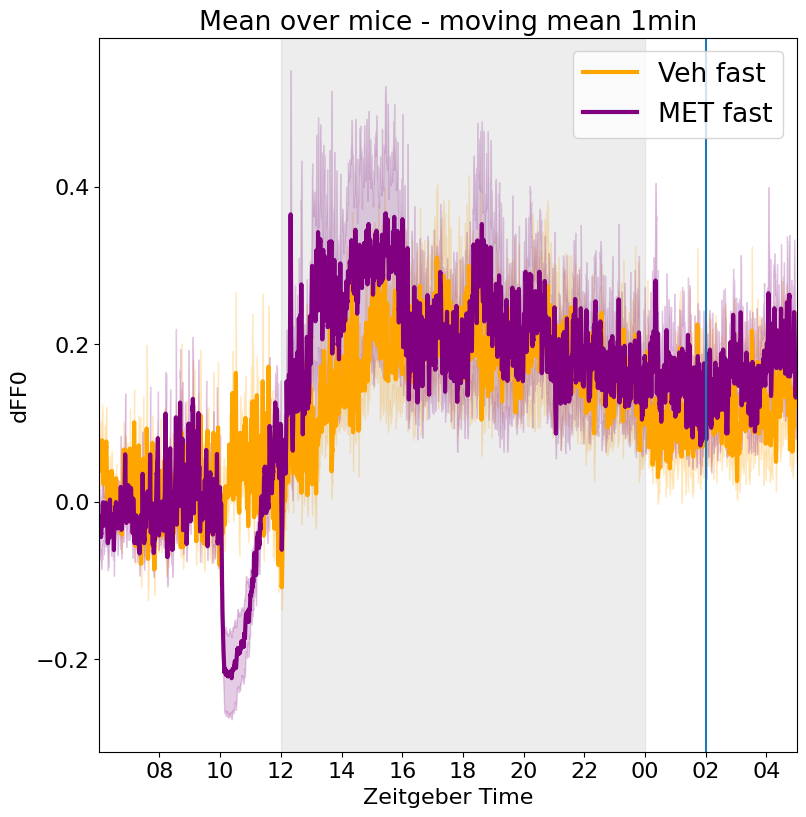

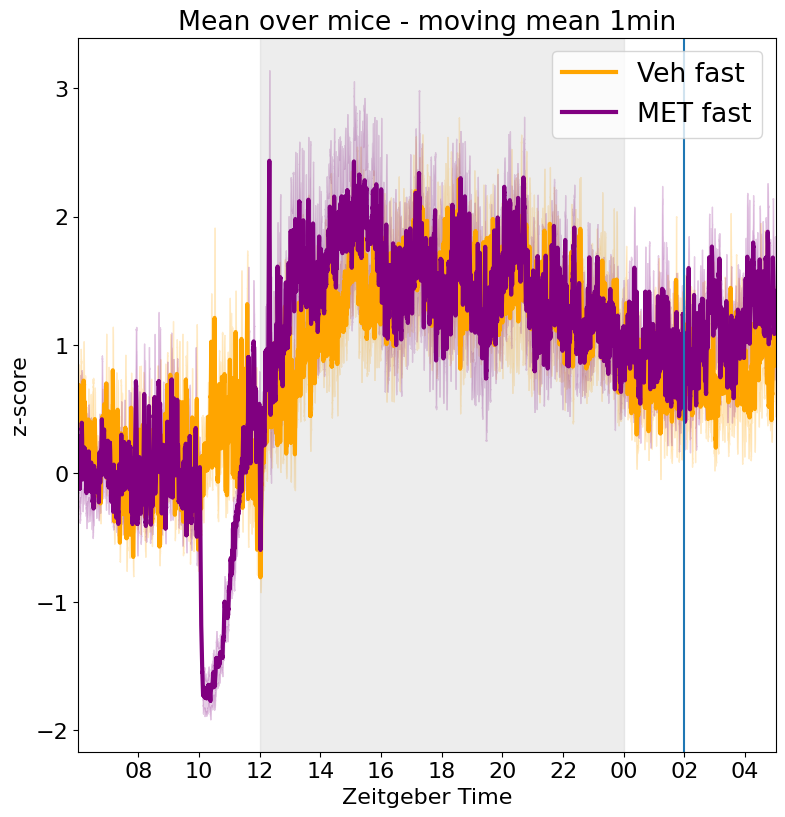

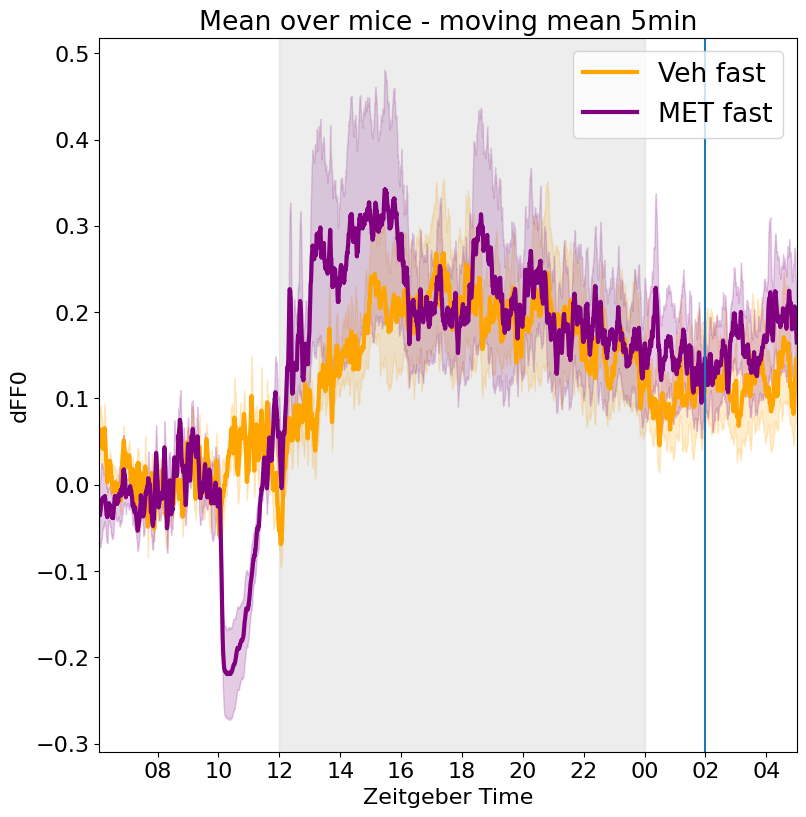

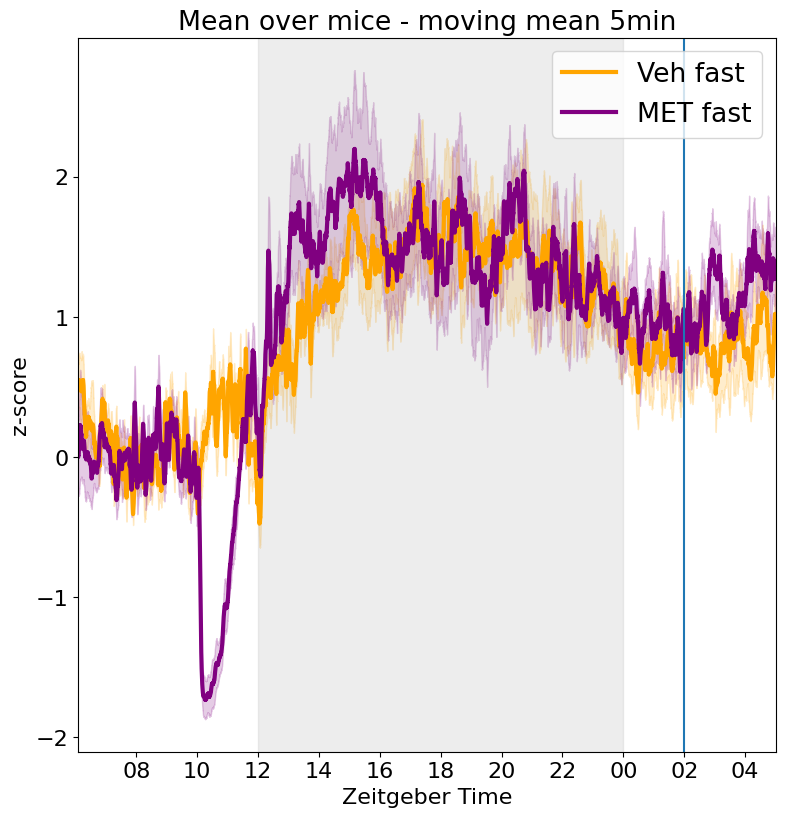

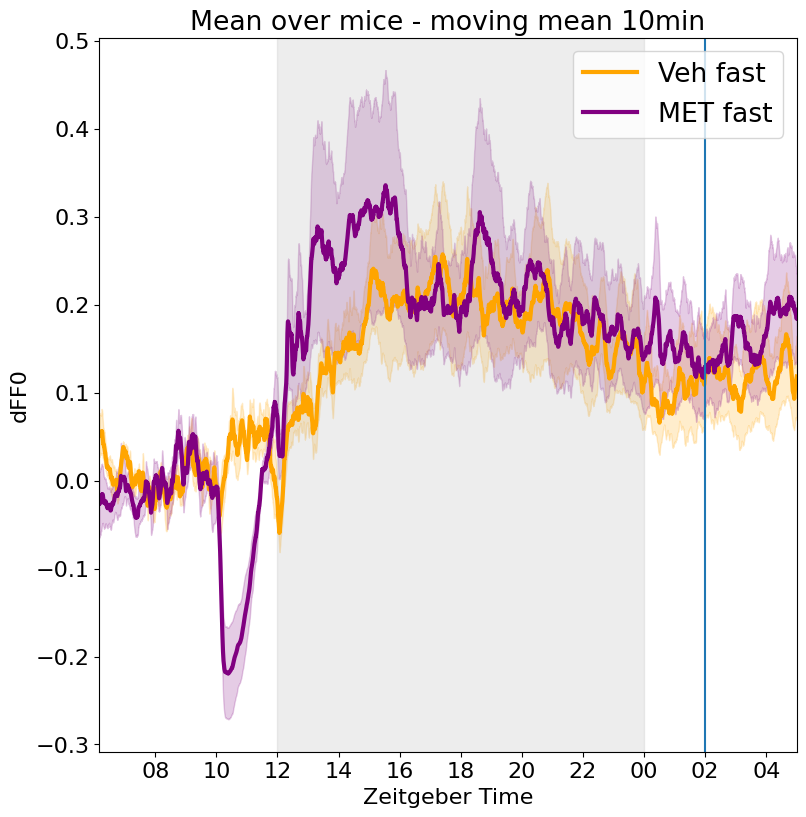

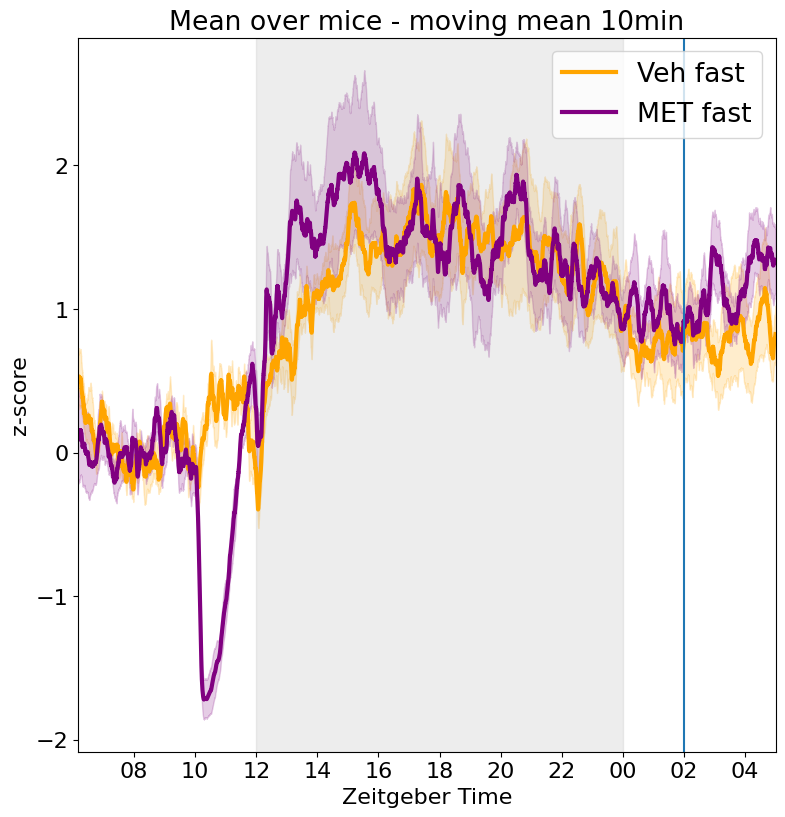

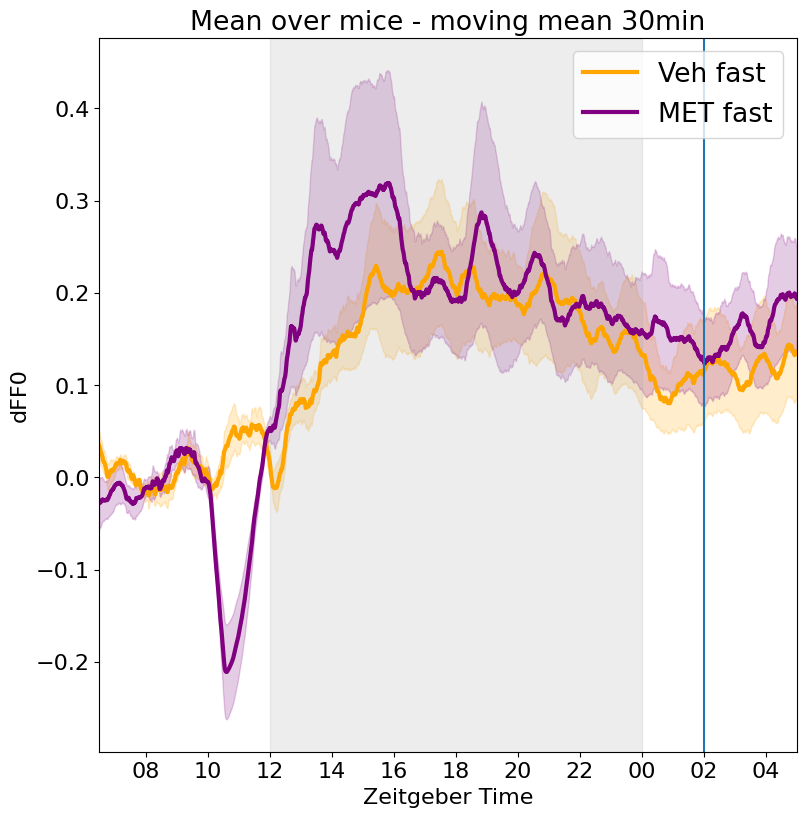

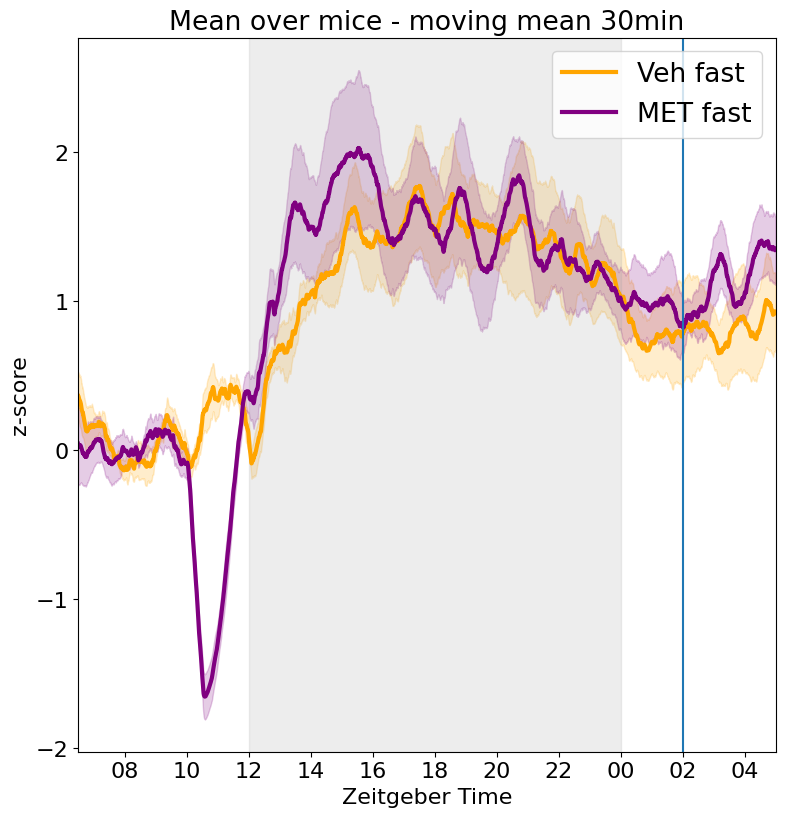

In [6]:
# Now plot different moving mean window values, dF/F0 and z-score in separate figures
for MM in MovingMeanVals:
    # Loop through dFF0/z-score
    for signal in Mean_Over_Mice[MM].keys():
        # Plot mean trace
        fig,ax = plt.subplots(1,1)
        Mean_Over_Mice[MM][signal].plot(color=ColorsToUse, linewidth=3, ax=ax)
        ax.set(ylabel = signal, xlabel = 'Zeitgeber Time', title = 'Mean over mice - moving mean '+str(MM)+'min')
        ax.legend(loc="upper right", fontsize="large")
        # Add SEM
        i=0
        for Stim in ConditionsToPlot:
            plt.fill_between(SEM_Over_Mice[MM][signal].index,
                        np.add(Mean_Over_Mice[MM][signal][Stim],SEM_Over_Mice[MM][signal][Stim]).tolist(),
                        np.subtract(Mean_Over_Mice[MM][signal][Stim],SEM_Over_Mice[MM][signal][Stim]).tolist(),
                        color = ColorsToUse[i], alpha=0.2)
            i=i+1
        # Shade in lights-off period (ZT12-ZT0) for each day
        ylim = ax.get_ylim()
        for j in list(range(1,len(list(set([i.day for i in list(Mean_Over_Mice[MM][signal].index)]))))):
            plt.fill_between([datetime.datetime(1,1,j,12,0,0),datetime.datetime(1,1,j+1,0,0,0)],[ylim[0],ylim[0]],[ylim[1],ylim[1]],
            color='darkgray', alpha=0.2)
        # Plot line to mark other events
        for j in list(EventLabels[EventLabels.notnull().any(axis=1)].index):
            ax.plot([j,j],ylim)
        ax.set_ylim(ylim)
        # change x tick labels to just show hours (not days)
        date_form = DateFormatter("%H")
        ax.xaxis.set_major_formatter(date_form)
        ax.set_xticks(ax.get_xticks()) # to suppress FixedLocator warning
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

        # save figure as .svg and .png
        figname = ("MM"+str(MM)+"mins_"+signal+"_"+ ', '.join(ConditionsToPlot))
        plt.savefig(figname+".svg")
        plt.savefig(figname+".png")


Plot just the time around lights-off.

In [7]:
Mean_Over_Mice.keys()

dict_keys([1, 5, 10, 30, 'Raw'])

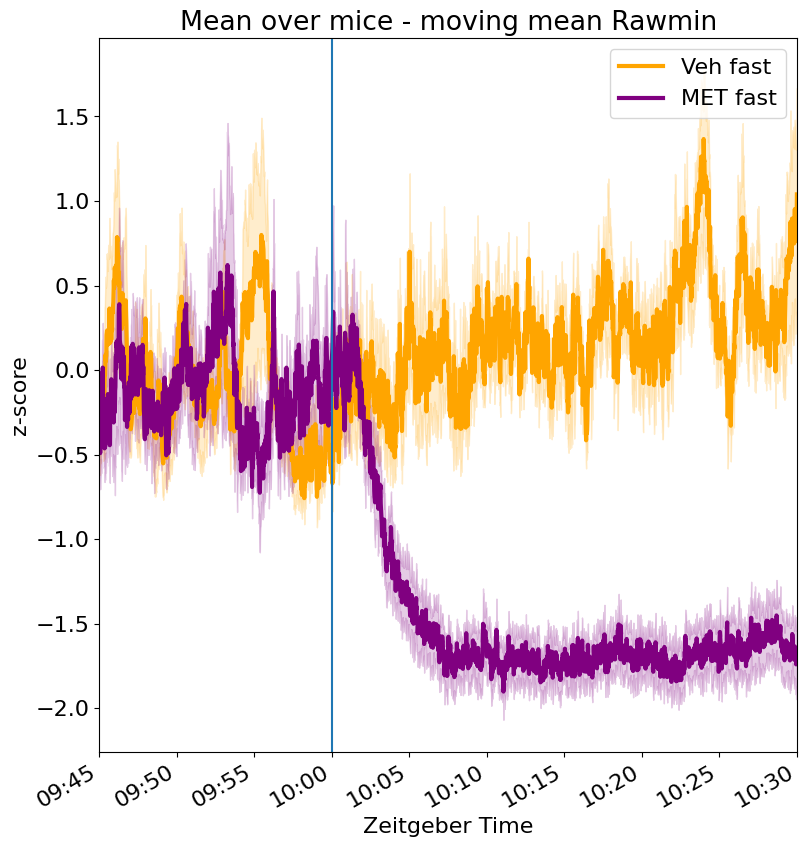

In [11]:
### Set these parameters:
PlotStartDay = 1
PlotStartTime = 9
PlotEndDay = 1
PlotEndTime = 12
EventTime = 10
MM = 10 # the moving mean window size to use (in mins)
signal = 'z-score' # the signal type to plot ('dFF0' or 'z-score)
###

Start = datetime.datetime(1,1,PlotStartDay,PlotStartTime,0)
End = datetime.datetime(1,1,PlotEndDay,PlotEndTime,0)
EventTime = datetime.datetime(1,1,1,EventTime,0)
ax = Mean_Over_Mice[MM][signal][Start:End].plot(color=ColorsToUse, linewidth=3)
ax.set(ylabel = signal, xlabel = 'Zeitgeber Time', title = 'Mean over mice - moving mean '+str(MM)+'min')
#add SEM
i=0
for Stim in ConditionsToPlot:
    plt.fill_between(Mean_Over_Mice[MM][signal][Start:End].index,
    np.add(Mean_Over_Mice[MM][signal][Stim][Start:End],SEM_Over_Mice[MM][signal][Stim][Start:End]).tolist(),
    np.subtract(Mean_Over_Mice[MM][signal][Stim][Start:End],SEM_Over_Mice[MM][signal][Stim][Start:End]).tolist(),
    color = ColorsToUse[i], alpha=0.2)
    i=i+1
ylim = ax.get_ylim()
ax.plot([EventTime,EventTime],ylim)
ax.set_ylim(ylim)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

plt.savefig('Closeup_Raw_30min.svg')
plt.savefig('Closeup_Raw_30min.png')

# Statistics
We will try two different measures of activity for statistical comparison: taking the mean activity over one minute at specific timepoints; and binning activity over 30 mins (or any bin size) at 30-min intervals.

For direct statistical comparison, first plot a boxplot of activity for each condition at specific timepoints, using moving mean with 1-min window. Each datapoint = average for 1 mouse.

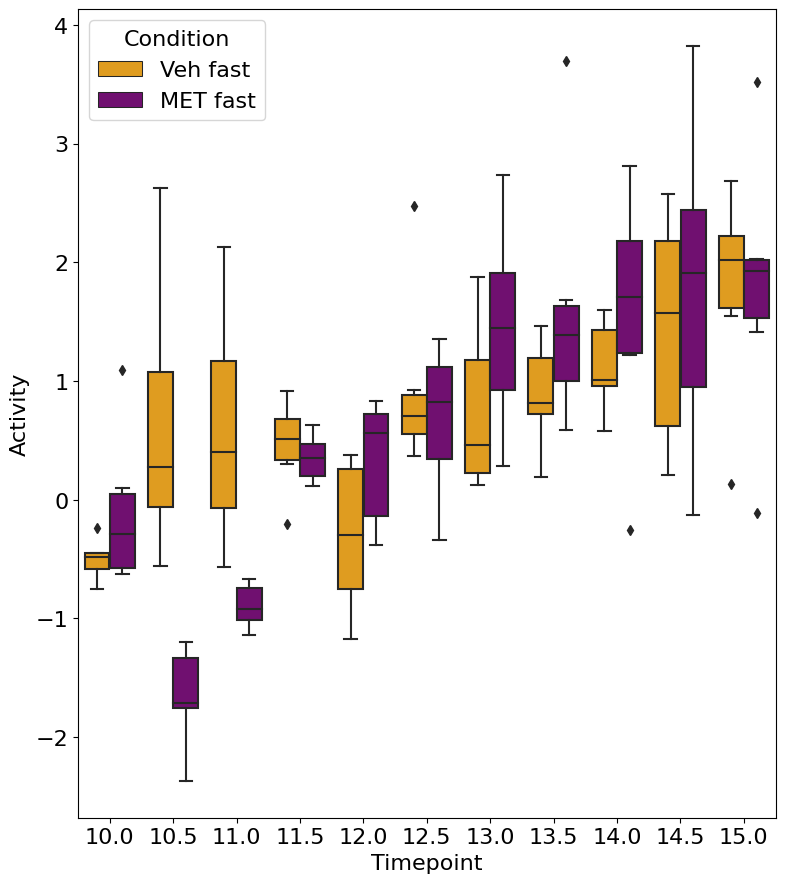

In [21]:
### Set times to quantify
times = date_range(datetime.datetime(1,1,1,10,0,0),datetime.datetime(1,1,1,15,0,0),30,'minutes')
###

# Dataframe with factors and datapoints
comp = pd.DataFrame({'Condition':[],
       'Mouse':[],
       'Timepoint':[],
       'Activity':[]})
for Stim in ConditionsToPlot:
    for Mouse in Mouse_Means[1]['z-score'].xs(Stim, level=1, axis=1).columns:
        for timepoint in times:
            comp.loc[len(comp.index)] = [Stim, Mouse, timepoint.hour + timepoint.minute/60, 
                    Mouse_Means[1]['z-score'][Mouse][Stim][timepoint]]

# Plot as boxplot
sns.boxplot(x='Timepoint', y='Activity', hue='Condition', data=comp, palette = colors)

plt.savefig('FoodRemoval_BoxPlot_MM1min.png')
plt.savefig('FoodRemoval_BoxPlot_MM1min.svg')

Statistical comparison: two-way repeated measures ANOVA, with timepoint and condition as factors. If the timepoint*condition interaction is signficant, follow up with post-hoc t-tests at each timepoint (with Bonferroni correction for multiple comparisons).

In [179]:
# Statistical test: two-way repeated measures ANOVA
res = pg.rm_anova(dv='Activity', within=['Timepoint', 'Condition'], subject='Mouse', 
                  data=comp, detailed=True)
res

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Timepoint,24.317231,6,30,4.052872,9.094842,0.000011,0.004007,0.466233,0.368091
1,Condition,8.066409,1,5,8.066409,24.565387,0.004262,0.004262,0.224653,1.000000
2,Timepoint * Condition,3.468211,6,30,0.578035,3.052202,0.018825,0.072039,0.110778,0.432389


In [180]:
# If there is a significant Timepoint*Condition interaction, test each timepoint separately (post-hoc)
# using two-way t-test (assuming two conditions):
TimePointComparison = {}
TimePointComparison_res = pd.DataFrame()
for timepoint in times:
    this_time = timepoint.hour + timepoint.minute/60
    TimePointComparison[this_time]=pd.DataFrame()
    for Stim in ConditionsToPlot:
        TimePointComparison[this_time][Stim] = Mouse_Means[1]['z-score'].xs(Stim,level=1,axis=1).loc[timepoint]
    with np.errstate(divide='ignore', invalid='ignore'):    #ignore runtime errors from Pingouin
        app = pg.ttest(TimePointComparison[this_time][ConditionsToPlot[0]],
                                                    TimePointComparison[this_time][ConditionsToPlot[1]],
                                                    paired=True)
    app.index = [this_time]
    TimePointComparison_res = pd.concat([TimePointComparison_res,app],axis=0)

# These p-values are uncorrected. Correct by multiplying the reported p-value by the number of comparisons
TimePointComparison_res['p_corrected'] = [np.min([i,1]) for i in TimePointComparison_res['p-val']*len(TimePointComparison_res.index)]
TimePointComparison_res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,p_corrected
12.0,0.890654,5,two-sided,0.413913,"[-0.17, 0.35]",0.282579,0.508,0.087901,1.000000
12.5,3.518864,5,two-sided,0.016940,"[0.24, 1.55]",1.710850,4.646,0.912522,0.118577
13.0,5.655607,5,two-sided,0.002401,"[0.78, 2.07]",2.745992,20.397,0.999387,0.016808
13.5,2.205637,5,two-sided,0.078535,"[-0.11, 1.39]",1.292299,1.508,0.716952,0.549742
14.0,1.934432,5,two-sided,0.110859,"[-0.17, 1.21]",0.577340,1.182,0.211408,0.776012
14.5,1.267033,5,two-sided,0.260952,"[-0.27, 0.8]",0.447469,0.667,0.146354,1.000000
15.0,1.302848,5,two-sided,0.249399,"[-0.49, 1.5]",0.585241,0.686,0.215879,1.000000


Repeat the tests as above, but this time using average activity over 30-minute bins.

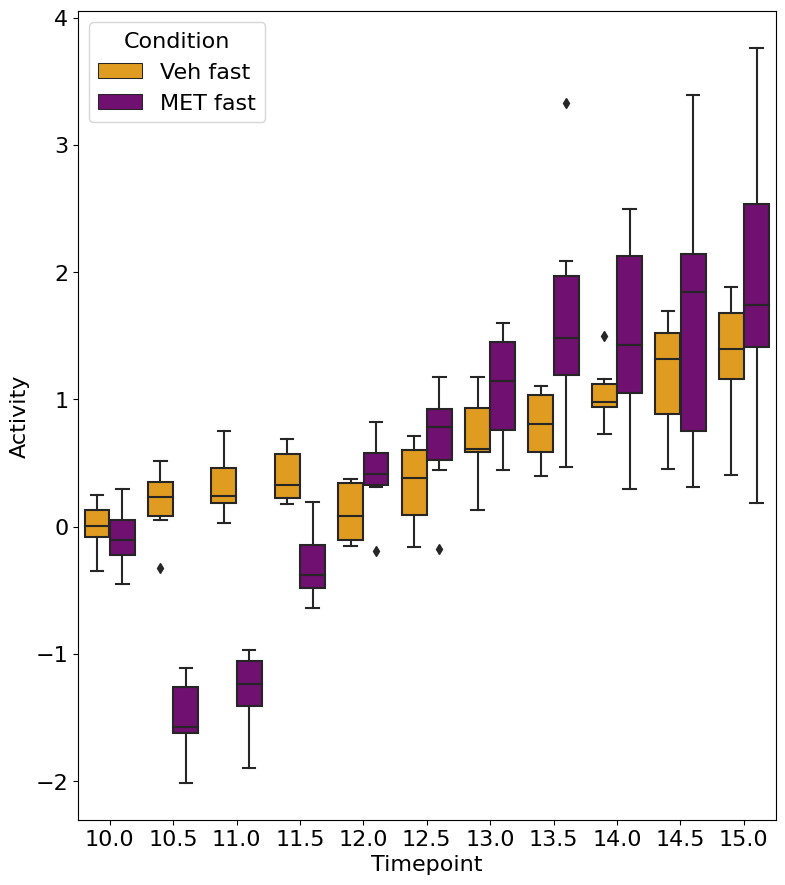

In [22]:
# Take average activity in 30min bins, instead of 1min mean at 30min intervals.
# Bin is from 29 mins before timepoint to timepoint (i.e. label is on right edge of bin).
binmins = 30 # interval between bins, in minutes
times = date_range(datetime.datetime(1,1,1,10,0,0),datetime.datetime(1,1,1,15,0,0),binmins,'minutes')

DataPoints_Bins = {}
MeanPoints_Bins = pd.DataFrame()

for Stim in ConditionsToPlot:
    DataPoints_Bins[Stim] = pd.DataFrame()
    for timepoint in times:
        this_time = timepoint.hour + timepoint.minute/60
        DataPoints_Bins[Stim][this_time] = Mouse_Means[1]['z-score'].xs(Stim,level=1,axis=1).loc[date_range(timepoint-datetime.timedelta(minutes=binmins-1),timepoint,1,'seconds')].mean()

# Dataframe with factors and datapoints
comp = pd.DataFrame({'Condition':[],
       'Mouse':[],
       'Timepoint':[],
       'Activity':[]})
for Stim in ConditionsToPlot:
    for Mouse in Mouse_Means[1]['z-score'].xs(Stim, level=1, axis=1).columns:
        for timepoint in DataPoints_Bins[Stim].columns:
            comp.loc[len(comp.index)] = [Stim, Mouse, timepoint, 
                    DataPoints_Bins[Stim][timepoint][Mouse]]

# Plot as boxplot
fig = sns.boxplot(x='Timepoint', y='Activity', hue='Condition', data=comp, palette = colors)

plt.savefig('FoodRemoval_BoxPlot_'+str(binmins)+'min-bins.png')
plt.savefig('FoodRemoval_BoxPlot_'+str(binmins)+'min-bins.svg')

In [23]:
# Statistical test: two-way repeated measures ANOVA
res_bins = pg.rm_anova(dv='Activity', within=['Timepoint', 'Condition'], subject='Mouse', 
                  data=comp, detailed=True)
res_bins

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Timepoint,75.16369,10,50,7.516369,33.992910,7.027136e-19,0.000174,0.692325,0.160339
1,Condition,0.12252,1,5,0.122520,0.102369,7.619428e-01,0.761943,0.003654,1.000000
2,Timepoint * Condition,23.55267,10,50,2.355267,16.435985,1.350485e-12,0.000715,0.413524,0.198661


In [24]:
# Post-hoc paired t-test for binned data (if 2 conditions)
TimePointComparison_Bins = {}
TimePointComparison_Bins_res = pd.DataFrame()
for timepoint in DataPoints_Bins[Stim].columns:
    TimePointComparison_Bins[timepoint]=pd.DataFrame()
    for Stim in ConditionsToPlot:
        TimePointComparison_Bins[timepoint][Stim] = DataPoints_Bins[Stim][timepoint]
    with np.errstate(divide='ignore', invalid='ignore'):    #ignore runtime errors from Pingouin
        app = pg.ttest(TimePointComparison_Bins[timepoint][ConditionsToPlot[0]],
                        TimePointComparison_Bins[timepoint][ConditionsToPlot[1]],
                        paired=True)
    app.index = [timepoint]
    TimePointComparison_Bins_res = pd.concat([TimePointComparison_Bins_res,app],axis=0)

# These p-values are uncorrected. Correct by multiplying the reported p-value by the number of comparisons
TimePointComparison_Bins_res['p_corrected'] = [np.min([i,1]) for i in 
                        TimePointComparison_Bins_res['p-val']*len(TimePointComparison_Bins_res.index)]
TimePointComparison_Bins_res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,p_corrected
10.0,0.871035,5,two-sided,0.423576,"[-0.16, 0.32]",0.343708,0.502,0.106371,1.000000
10.5,9.290183,5,two-sided,0.000243,"[1.22, 2.16]",5.380942,120.007,1.000000,0.002674
11.0,8.962959,5,two-sided,0.000288,"[1.16, 2.09]",5.303717,105.05,1.000000,0.003171
11.5,4.263011,5,two-sided,0.007992,"[0.27, 1.11]",2.596070,8.171,0.998488,0.087911
12.0,-1.905525,5,two-sided,0.115045,"[-0.68, 0.1]",0.963731,1.152,0.479053,1.000000
12.5,-1.083339,5,two-sided,0.328112,"[-1.12, 0.46]",0.794223,0.58,0.352008,1.000000
13.0,-2.583380,5,two-sided,0.049230,"[-0.79, -0.0]",0.940407,2.112,0.461200,0.541531
13.5,-1.991963,5,two-sided,0.102991,"[-2.0, 0.25]",1.208376,1.245,0.660883,1.000000
14.0,-1.240001,5,two-sided,0.269993,"[-1.36, 0.48]",0.720989,0.653,0.300800,1.000000
14.5,-1.457415,5,two-sided,0.204793,"[-1.33, 0.37]",0.545607,0.779,0.194028,1.000000


In [87]:
# Post-hoc ANOVA for binned data (if >2 conditions)
TimePointComparison_Bins = {}
TimePointComparison_Bins_res = pd.DataFrame()
for timepoint in DataPoints_Bins[Stim].columns:
    res = pg.rm_anova(data = comp[comp['Timepoint']==timepoint], dv='Activity', within = 'Condition', subject='Mouse', detailed=True).loc[0]
    res.name = timepoint
    TimePointComparison_Bins_res = pd.concat([TimePointComparison_Bins_res,res],axis=1)
TimePointComparison_Bins_res

,12.0,12.5,13.0,13.5,14.0,14.5,15.0
Source,Condition,Condition,Condition,Condition,Condition,Condition,Condition
SS,0.123779,1.371376,2.629295,3.650405,7.736277,13.752546,9.865496
DF,2,2,2,2,2,2,2
MS,0.061889,0.685688,1.314647,1.825203,3.868139,6.876273,4.932748
F,1.578791,18.697411,19.440094,13.866791,16.265052,24.767941,26.960546
p-unc,0.23672,0.000065,0.000052,0.000321,0.00014,0.000013,0.000008
ng2,0.121121,0.499915,0.529618,0.458011,0.468125,0.499567,0.541514
eps,0.681913,0.813206,0.949169,0.92292,0.824875,0.707829,0.902564


In [90]:
# Post-hoc t-test for specific conditions
Conditions_to_test = ['choc 6pm fast', 'choc 6pm calorie-free']

TimePointComparison_Bins = {}
TimePointComparison_Bins_res = pd.DataFrame()
for timepoint in DataPoints_Bins[Stim].columns:
    TimePointComparison_Bins[timepoint]=pd.DataFrame()
    for Stim in Conditions_to_test:
        TimePointComparison_Bins[timepoint][Stim] = DataPoints_Bins[Stim][timepoint]
    with np.errstate(divide='ignore', invalid='ignore'):    #ignore runtime errors from Pingouin
        app = pg.ttest(TimePointComparison_Bins[timepoint][Conditions_to_test[0]],
                        TimePointComparison_Bins[timepoint][Conditions_to_test[1]],
                        paired=True)
    app.index = [timepoint]
    TimePointComparison_Bins_res = pd.concat([TimePointComparison_Bins_res,app],axis=0)

# These p-values are uncorrected. Correct by multiplying the reported p-value by the number of comparisons
TimePointComparison_Bins_res['p_corrected'] = [np.min([i,1]) for i in 
                        TimePointComparison_Bins_res['p-val']*len(TimePointComparison_Bins_res.index)]
TimePointComparison_Bins_res

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,p_corrected
12.0,2.361642,8,two-sided,0.045841,"[0.0, 0.31]",0.941943,1.949,0.697676,0.320884
12.5,4.751525,8,two-sided,0.001442,"[0.17, 0.49]",1.464320,30.43,0.968823,0.010097
13.0,1.580671,8,two-sided,0.152609,"[-0.08, 0.42]",0.514090,0.814,0.274887,1.000000
13.5,0.569012,8,two-sided,0.584965,"[-0.34, 0.56]",0.252418,0.369,0.102838,1.000000
14.0,1.990209,8,two-sided,0.081747,"[-0.05, 0.73]",0.484087,1.268,0.249380,0.572226
14.5,2.224407,8,two-sided,0.056790,"[-0.01, 0.68]",0.364873,1.659,0.162206,0.397533
15.0,0.805910,8,two-sided,0.443589,"[-0.26, 0.53]",0.195795,0.42,0.081528,1.000000


C:\Users\sjwal\AppData\Local\Temp\ipykernel_20580\445368575.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zt12_pre['Timepoint'] = zt12_pre['Timepoint'].replace(12.0 - times[0],'pre')
C:\Users\sjwal\AppData\Local\Temp\ipykernel_20580\445368575.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zt12_post['Timepoint'] = zt12_post['Timepoint'].replace(12.0 + times[1],'post')
C:\Users\sjwal\AppData\Local\Temp\ipykernel_20580\445368575.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy 

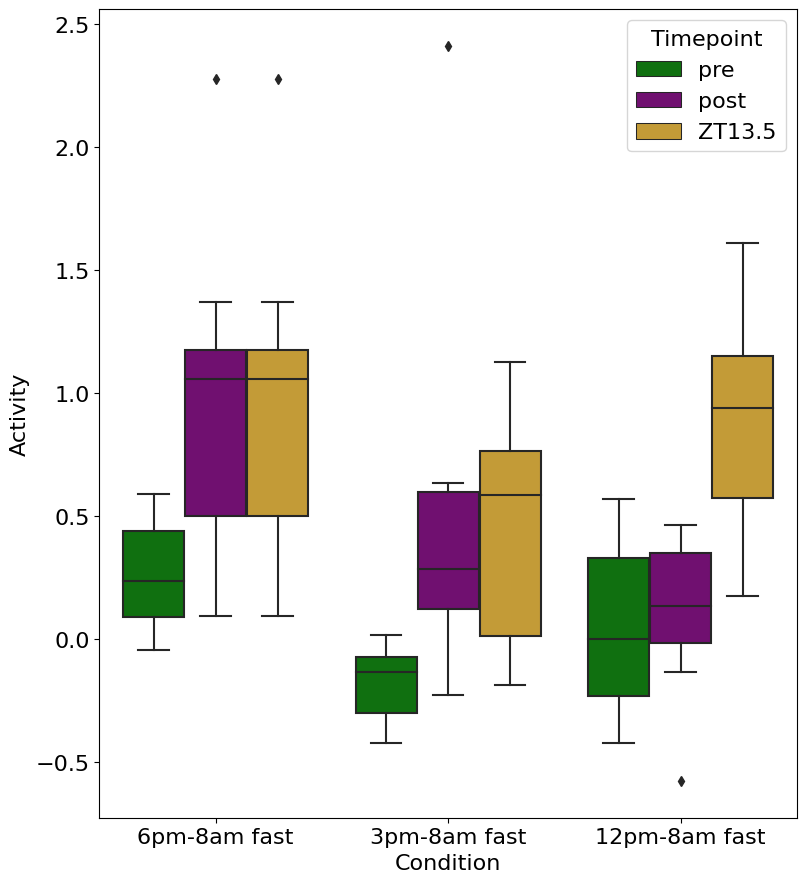

In [197]:
# Plot boxplot: for each condition, 1h before food removal vs 1h after vs ZT13
# also try 1h before vs 2h after vs ZT14
times = [1.0,1.5,13.5] #[h before removal / h after removal / zt time for comparison]
zt12 = comp[comp['Condition'] == '6pm-8am fast']
zt12_pre = zt12[zt12['Timepoint'] == 12.0 - times[0]]
zt12_post = zt12[zt12['Timepoint'] == 12.0 + times[1]]
zt12_zt13 = zt12[zt12['Timepoint'] == times[2]]

zt12_pre['Timepoint'] = zt12_pre['Timepoint'].replace(12.0 - times[0],'pre')
zt12_post['Timepoint'] = zt12_post['Timepoint'].replace(12.0 + times[1],'post')
zt12_zt13['Timepoint'] = zt12_zt13['Timepoint'].replace(times[2],'ZT'+str(times[2]))

zt9 = comp[comp['Condition'] == '3pm-8am fast']
zt9_pre = zt9[zt9['Timepoint'] == 9.0 - times[0]]
zt9_post = zt9[zt9['Timepoint'] == 9.0 + times[1]]
zt9_zt13 = zt9[zt9['Timepoint'] == times[2]]

zt9_pre['Timepoint'] = zt9_pre['Timepoint'].replace(9.0 - times[0],'pre')
zt9_post['Timepoint'] = zt9_post['Timepoint'].replace(9.0 + times[1],'post')
zt9_zt13['Timepoint'] = zt9_zt13['Timepoint'].replace(times[2],'ZT'+str(times[2]))

zt6 = comp[comp['Condition'] == '12pm-8am fast']
zt6_pre = zt6[zt6['Timepoint'] == 6.0 - times[0]]
zt6_post = zt6[zt6['Timepoint'] == 6.0 + times[1]]
zt6_zt13 = zt6[zt6['Timepoint'] == times[2]]

zt6_pre['Timepoint'] = zt6_pre['Timepoint'].replace(6.0 - times[0],'pre')
zt6_post['Timepoint'] = zt6_post['Timepoint'].replace(6.0 + times[1],'post')
zt6_zt13['Timepoint'] = zt6_zt13['Timepoint'].replace(times[2],'ZT'+str(times[2]))

to_plot = pd.concat([zt12_pre,zt12_post,zt12_zt13,zt9_pre,zt9_post,zt9_zt13,zt6_pre,zt6_post,zt6_zt13])

fig = sns.boxplot(x='Condition', y='Activity', hue='Timepoint', data=to_plot, palette = colors)

plt.savefig('boxplot_2h_after_removal_vs_ZT13-5.svg')
plt.savefig('boxplot_2h_after_removal_vs_ZT13-5.png')


In [195]:
zt6

,Condition,Mouse,Timepoint,Activity
270,12pm-8am fast,A4085,11.0,0.670795
271,12pm-8am fast,A4085,11.5,0.260812
272,12pm-8am fast,A4085,12.0,0.688196
273,12pm-8am fast,A4085,12.5,0.505772
274,12pm-8am fast,A4085,13.0,0.908379
...,...,...,...,...
355,12pm-8am fast,A3396,13.0,2.594299
356,12pm-8am fast,A3396,13.5,0.480198
357,12pm-8am fast,A3396,14.0,0.926999
358,12pm-8am fast,A3396,14.5,1.811234


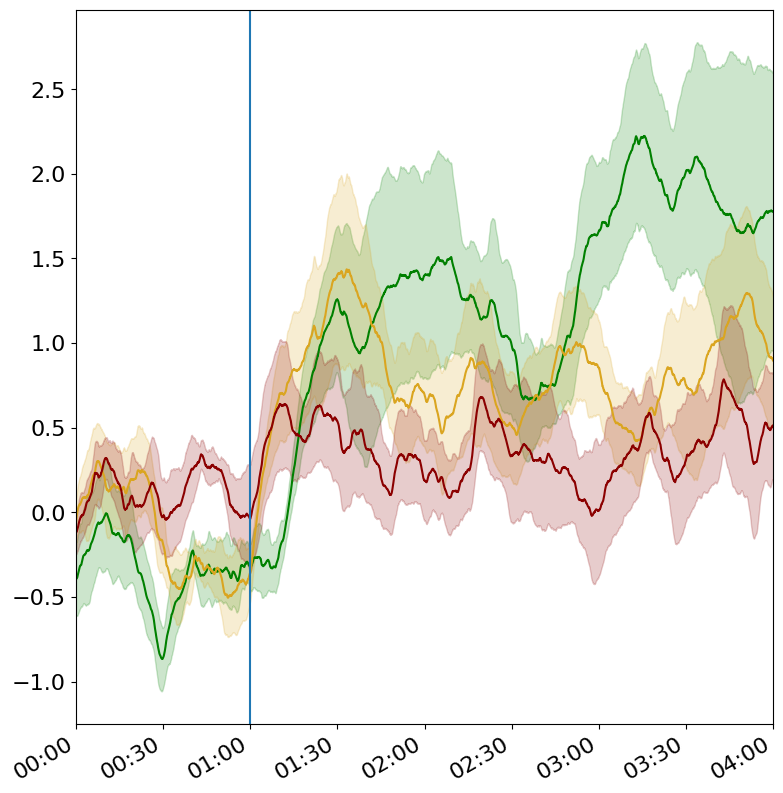

In [228]:
# Align to different times

conds = ['6pm-8am fast', '3pm-8am fast', '12pm-8am fast']
times = [12,9,6]
cond_nums = [0,2,3]

fig, ax = plt.subplots(1,1)
for n in range(len(conds)):
    this_time_mean = Mean_Over_Mice[MM][signal][datetime.datetime(1,1,1,times[n]-1,0):datetime.datetime(1,1,1,times[n]+3,0)][conds[n]]
    this_time_mean.index = date_range(datetime.datetime(1,1,1,0,0),datetime.datetime(1,1,1,4,0),1,'seconds')
    this_time_mean.plot(ax=ax, label='ZT'+str(times[n]), color=ColorsToUse[cond_nums[n]])

    this_time_sem = SEM_Over_Mice[MM][signal][datetime.datetime(1,1,1,times[n]-1,0):datetime.datetime(1,1,1,times[n]+3,0)][conds[n]]
    this_time_sem.index = date_range(datetime.datetime(1,1,1,0,0),datetime.datetime(1,1,1,4,0),1,'seconds')
    plt.fill_between(this_time_sem.index,
                    np.add(this_time_mean,this_time_sem).tolist(), np.subtract(this_time_mean,this_time_sem).tolist(),
                    color = ColorsToUse[cond_nums[n]], alpha=0.2)

ylim = ax.get_ylim()
ax.plot([datetime.datetime(1,1,1,1,0),datetime.datetime(1,1,1,1,0)],ylim)
ax.set_ylim(ylim)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

plt.savefig('Aligned_To_Food_Removal.svg')
plt.savefig('Aligned_To_Food_Removal.png')

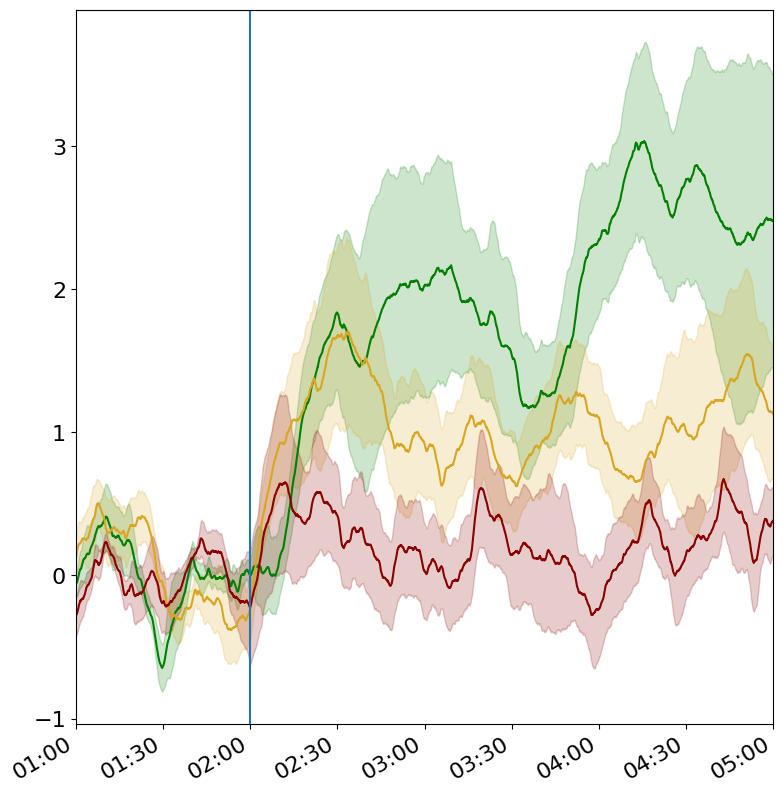

In [229]:
# Normalize to activity prior to food removal
fig, ax = plt.subplots(1,1)
for n in range(len(conds)):
    # get raw trials for this condition
    this_time_raw = AllTrials['Raw_DS'].xs(conds[n], level=2, axis=1)
    this_time_raw = this_time_raw[datetime.datetime(1,1,1,times[n]-2,0):datetime.datetime(1,1,1,times[n]+4,0)]
    this_time_raw.index = date_range(datetime.datetime(1,1,1,0,0),datetime.datetime(1,1,1,6,0),1,'seconds')
    # calculate dF/F0 and z-score it
    this_time_F0 = this_time_raw[datetime.datetime(1,1,1,1,0):datetime.datetime(1,1,1,1,59)].mean(axis=0)
    this_time_dFF0 = (this_time_raw - this_time_F0) / this_time_F0
    this_time_sd = np.std(this_time_dFF0[datetime.datetime(1,1,1,1,0):datetime.datetime(1,1,1,1,59)])
    this_time_zs = this_time_dFF0 / this_time_sd
    # take moving mean (10-minute window)
    this_time_mm = this_time_zs.rolling(window=10*60*AllTrials['DownSamplingRate'][0], center = False).mean()
    # take mean and SEM over trials
    this_time_mean = this_time_mm[datetime.datetime(1,1,1,1,0):datetime.datetime(1,1,1,5,0)].mean(axis=1)
    this_time_sem = this_time_mm[datetime.datetime(1,1,1,1,0):datetime.datetime(1,1,1,5,0)].sem(axis=1)
    
    this_time_mean.plot(ax=ax, label='ZT'+str(times[n]), color=ColorsToUse[cond_nums[n]])

    plt.fill_between(this_time_sem.index,
                    np.add(this_time_mean,this_time_sem).tolist(), np.subtract(this_time_mean,this_time_sem).tolist(),
                    color = ColorsToUse[cond_nums[n]], alpha=0.2)

ylim = ax.get_ylim()
ax.plot([datetime.datetime(1,1,1,2,0),datetime.datetime(1,1,1,2,0)],ylim)
ax.set_ylim(ylim)
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)

plt.savefig('Aligned_To_Food_Removal_Norm.svg')
plt.savefig('Aligned_To_Food_Removal_Norm.png')

In [215]:
this_time_raw = AllTrials['Raw_DS'].xs('12pm-8am fast', level=2, axis=1)
this_time_raw = this_time_raw[datetime.datetime(1,1,1,times[n]-1,0):datetime.datetime(1,1,1,times[n]+3,0)]
this_time_raw.index = date_range(datetime.datetime(1,1,1,0,0),datetime.datetime(1,1,1,4,0),1,'seconds')
this_time_F0 = this_time_raw[datetime.datetime(1,1,1,0,0):datetime.datetime(1,1,1,0,59)].mean(axis=0)
this_time_dFF0 = (this_time_raw - this_time_F0) / this_time_F0
this_time_sd = np.std(this_time_dFF0[datetime.datetime(1,1,1,0,0):datetime.datetime(1,1,1,0,59)])
this_time_zs = this_time_dFF0 / this_time_sd
this_time_mean = this_time_zs.mean(axis=1)
this_time_sem = this_time_zs.sem(axis=1)

0001-01-01 00:00:00    0.105782
0001-01-01 00:00:01   -0.046643
0001-01-01 00:00:02   -0.133668
0001-01-01 00:00:03   -0.047786
0001-01-01 00:00:04   -0.095728
                         ...   
0001-01-01 03:59:56    0.252126
0001-01-01 03:59:57    0.437314
0001-01-01 03:59:58    0.384770
0001-01-01 03:59:59    0.523413
0001-01-01 04:00:00    0.153484
Length: 14401, dtype: float64